In [87]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from fcmeans import FCM  

In [88]:
BASE_DIR = "/kaggle/input/raabindata-nucleus-cytoplasm-ground-truths/GrTh"

ORIGINAL_PATH = os.path.join(BASE_DIR, "Original")
GT_PATH = os.path.join(BASE_DIR, "Ground Truth")

CLASSES = ["Basophil", "Eosinophil", "Lymphocyte", "Monocyte", "Neutrophil"]

In [89]:
BASE_PATH = "/kaggle/input/raabindata-nucleus-cytoplasm-ground-truths/GrTh"
ORIGINAL_PATH = os.path.join(BASE_PATH, "Original")
GT_PATH = os.path.join(BASE_PATH, "Ground Truth")

CELL_TYPE = "Neutrophil"

orig_dir = os.path.join(ORIGINAL_PATH, CELL_TYPE)
gt_dir = os.path.join(GT_PATH, CELL_TYPE)

img_name = os.listdir(orig_dir)[100]
print(img_name)

95-5-10-1_393_1.jpg


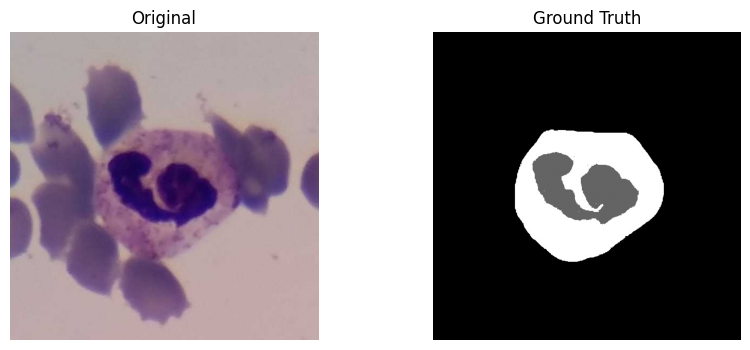

In [90]:
img=cv2.imread(os.path.join(orig_dir, img_name))
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gt=cv2.imread(os.path.join(gt_dir,img_name), 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Ground Truth")
plt.imshow(gt, cmap="gray")
plt.axis("off")

plt.show()

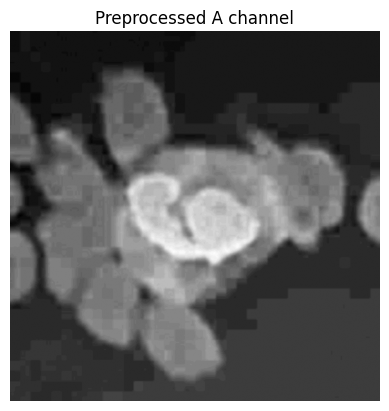

In [91]:
lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
L, A, B = cv2.split(lab)
A_blur = cv2.GaussianBlur(A, (5,5), 0)
X = A_blur.reshape(-1, 1)

plt.imshow(A_blur,cmap="gray")
plt.title("Preprocessed A channel")
plt.axis("off")
plt.show()

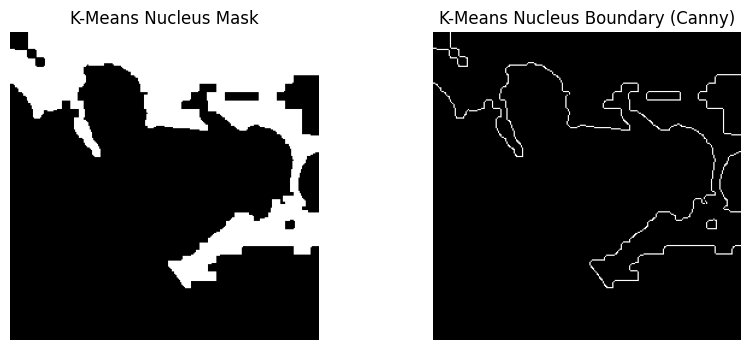

In [92]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_resized = cv2.resize(img_hsv, (256,256))
X = img_resized.reshape((-1, 3)).astype(np.float32)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)

K = 3
_, labels, centers = cv2.kmeans(
    X, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
)

labels = labels.flatten()
seg_kmeans = labels.reshape(img_resized.shape[:2])

nucleus_cluster = np.argmin(centers.sum(axis=1))
nucleus_kmeans = (seg_kmeans == nucleus_cluster).astype(np.uint8)

kernel = np.ones((5,5), np.uint8)
nucleus_kmeans = cv2.morphologyEx(nucleus_kmeans, cv2.MORPH_OPEN, kernel)

num_labels, cc, stats, centroids = cv2.connectedComponentsWithStats(nucleus_kmeans)

if num_labels > 1:
    largest = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    nucleus_kmeans = (cc == largest).astype(np.uint8)

boundary_kmeans = cv2.Canny(nucleus_kmeans*255, 50, 150)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("K-Means Nucleus Mask")
plt.imshow(nucleus_kmeans, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("K-Means Nucleus Boundary (Canny)")
plt.imshow(boundary_kmeans, cmap="gray")
plt.axis("off")

plt.show()

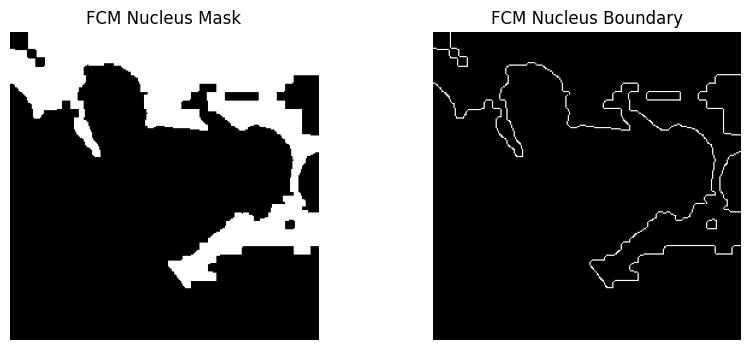

In [93]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

def fuzzy_c_means_no_random(X, c=3, m=2, max_iter=100, error=1e-5):
    n = X.shape[0]
    u = np.zeros((n, c), dtype=float)

    for i in range(n):
        r = [random.random() for _ in range(c)]
        s = sum(r)
        u[i] = [x / s for x in r]

    for _ in range(max_iter):
        u_old = u.copy()
        um = u ** m
        centers = (um.T @ X) / np.sum(um.T, axis=1, keepdims=True)
        dist = np.zeros((n, c))
        for j in range(c):
            dist[:, j] = np.linalg.norm(X - centers[j], axis=1)**2
        dist = np.fmax(dist, 1e-10)
        for j in range(c):
            denom = np.sum((dist[:, j][:, None] / dist) ** (1/(m-1)), axis=1)
            u[:, j] = 1 / denom
        if np.linalg.norm(u - u_old) < error:
            break

    return centers, u

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_resized = cv2.resize(img_hsv, (256,256))
X = img_resized.reshape((-1, 3)).astype(np.float32)

centers, u = fuzzy_c_means_no_random(X, c=3, m=2, max_iter=50)

cluster_brightness = centers.sum(axis=1)
nucleus_cluster = np.argmin(cluster_brightness)

membership = u[:, nucleus_cluster]
nucleus_fcm = membership.reshape(img_resized.shape[:2])
nucleus_fcm = (nucleus_fcm > 0.6).astype(np.uint8)

kernel = np.ones((5,5), np.uint8)
nucleus_fcm = cv2.morphologyEx(nucleus_fcm, cv2.MORPH_OPEN, kernel)

_, cc, stats, _ = cv2.connectedComponentsWithStats(nucleus_fcm)
if stats.shape[0] > 1:
    largest = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    nucleus_fcm = (cc == largest).astype(np.uint8)

boundary_fcm = cv2.Canny(nucleus_fcm*255, 50, 150)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("FCM Nucleus Mask"); plt.imshow(nucleus_fcm, cmap='gray'); plt.axis("off")
plt.subplot(1,2,2); plt.title("FCM Nucleus Boundary"); plt.imshow(boundary_fcm, cmap='gray'); plt.axis("off")
plt.show()

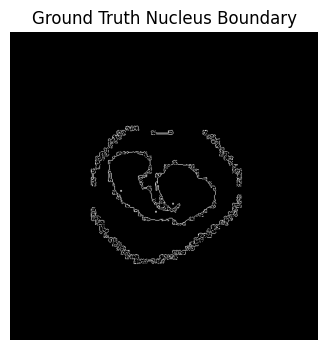

In [94]:

gt_nucleus = ((gt > 0) & (gt < 255)).astype(np.uint8)

boundary_gt = cv2.Canny(gt_nucleus * 255, 50, 150)

plt.figure(figsize=(4,4))
plt.imshow(boundary_gt, cmap="gray")
plt.title("Ground Truth Nucleus Boundary")
plt.axis("off")
plt.show()

In [95]:
gt_nucleus = ((gt > 0) & (gt < 255)).astype(np.uint8)
boundary_gt = cv2.Canny(gt_nucleus * 255, 50, 150).astype(bool)
boundary_kmeans = boundary_kmeans.astype(bool)
boundary_fcm    = boundary_fcm.astype(bool)

def boundary_points(boundary_mask):
    """Return (row, col) coordinates of all boundary pixels."""
    return np.column_stack(np.nonzero(boundary_mask))


gt_pts  = boundary_points(boundary_gt)
km_pts  = boundary_points(boundary_kmeans)
fcm_pts = boundary_points(boundary_fcm)

def pairwise_distances(A, B):
    """
    Compute Euclidean distance matrix between two point sets A & B.
    A shape: (N, 2)
    B shape: (M, 2)
    Returns matrix (N, M)
    """
    A = A[:, None, :]  
    B = B[None, :, :]  
    return np.linalg.norm(A - B, axis=2)


def average_boundary_distance(A, B):
    """
    For each point in A, compute distance to nearest point in B,
    then average these distances.
    """
    dist_matrix = pairwise_distances(A, B)
    return np.mean(dist_matrix.min(axis=1))

abd_kmeans = average_boundary_distance(km_pts, gt_pts)
abd_fcm    = average_boundary_distance(fcm_pts, gt_pts)

print("Average Boundary Distance (K-Means):", abd_kmeans)
print("Average Boundary Distance (FCM):", abd_fcm)

Average Boundary Distance (K-Means): 110.8079368944403
Average Boundary Distance (FCM): 111.3877978140525
